<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/jax/bayesian_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description:** This notebook demonstrates the application of PGD, PQN, PMGD, and SOUL to the Bayesian neural network considered in Section 3.2 of [Scalable particle-based alternatives to EM](https://juankuntz.github.io/publication/parem/) and reproduces Figure 4 and Table 2 therein. 

# Figure 4

First, we load the modules we need:

In [ ]:
#@title Load modules.

# Numpy and JAX for computations.
import numpy as np
import jax
import jax.numpy as jnp

# Pyplot for plots.
import matplotlib.pyplot as plt 

Next, we load and curate the dataset:

In [ ]:
#@title Load, subsample, and normalize MNIST dataset.

# Load dataset:
from keras.datasets import mnist
(images, labels), _ = mnist.load_data()
images = np.array(images).astype(float)
labels = np.array(labels).astype(int)

# Keep only datapoints with labels 4 and 9:
indices = (labels == 4) | (labels == 9)
labels = labels[indices]
images = images[indices, :, :]

# Relabel as 4 as 0 and 9 as 1:
for n in range(labels.size):
    if labels[n] == 4:
        labels[n] = 0
    else:
        labels[n] = 1

# Sub-sample 1000 images:
from sklearn.model_selection import train_test_split
images, _, labels, _ = train_test_split(images, labels, train_size=1000,
                                        random_state=0)

# Normalize non-zero entries so that they have mean zero and unit standard 
# across the dataset:'''
i = images.std(0) != 0
images[:, i] = (images[:, i] - images[:, i].mean(0))/images[:, i].std(0)

2022-10-25 18:38:26.474295: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 18:38:26.495100: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-25 18:38:27.000421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-25 18:38:27.000537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-25 18:38:27.000544: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

We then implement the algorithms. They take in the following inputs:

*   itrain : training set labels,
*   itrain : training set images,
*   itest : test set labels,
*   itest : test set images,
*   h : step-size,
*   K : number of steps,
*   N : number of particles,
*   a : 1-dimensional vector with initial alpha guess,
*   b : 1-dimensional vector with initial beta guess,
*   w : Dw x N matrix storing the input layer weights of the initial particle cloud,
*   v : Dv x N matrix storing the output layer weights of the initial particle cloud.

They return the following outputs:

*   a : K-dimensional vector of alpha estimates,
*   b : K-dimensional vector of beta estimates,
*   w : Dw x N matrix storing the input layer weights of the final particle cloud,
*   v : Dv x N matrix storing the output layer weights of the final particle cloud,
*   lppd : log pointwise predictive density (LPPD) as a function of k,
*   error : test error as a function of k.

In [ ]:
#@title Implement algorithms.

# Algorithms.

def pgd(ltrain, itrain, ltest, itest, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    # Initialize arrays storing performance metrics as a function of k:
    lppd = np.zeros(K)  # Log pointwise predictive density (LPPD).
    error = np.zeros(K)  # Test error.

    for k in range(K):
        # Evaluate metrics for current particle cloud:
        lppd[k] = log_pointwise_predrictive_density(w, v, itest, ltest)
        error[k] = test_error(w, v, itest, ltest)

        # Temporarily store current particle cloud:
        wk = w  # Input layer weights.
        vk = v  # Output layer weights.

        # Update parameter estimates (note that we are using the heuristic 
        # discussed in Section 2.1 of the paper; i.e., dividing the 
        # alpha-gradient by Dw and the beta-gradient by Dv):
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])/Dv)  # Beta.

        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v, lppd, error


def pqn(ltrain, itrain, ltest, itest, h, K, a, b, w, v):
    # Initialize arrays storing performance metrics as a function of k:
    lppd = np.zeros(K)  # Log pointwise predictive density (LPPD).
    error = np.zeros(K)  # Test error.

    for k in range(K):
        # Evaluate metrics for current particle cloud:
        lppd[k] = log_pointwise_predrictive_density(w, v, itest, ltest)
        error[k] = test_error(w, v, itest, ltest)

        # Temporarily store current particle cloud:
        wk = w  # Input layer weights.
        vk = v  # Output layer weights

        # Update parameter estimates:
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])
                                /ave_neg_hess_param(wk, a[k]))  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])
                                  /ave_neg_hess_param(vk, b[k]))  # Beta.
        
        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v, lppd, error


def pmga(ltrain, itrain, ltest, itest, h, K, w, v):
    # Initialize arrays storing performance metrics as a function of k:
    lppd = np.zeros(K)  # Log pointwise predictive density (LPPD).
    error = np.zeros(K)  # Test error.

    # Compute initial parameter estimates:
    a = np.array([optimal_param(w)])  # Alpha.
    b = np.array([optimal_param(v)])  # Beta.

    for k in range(K):
        # Evaluate metrics for current particle cloud:
        lppd[k] = log_pointwise_predrictive_density(w, v, itest, ltest)
        error[k] = test_error(w, v, itest, ltest)

        # Temporarily store current particle cloud:
        wk = w  # Input layer weights.
        vk = v  # Output layer weights.
        
        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

        # Update parameter estimates:
        a = np.append(a, optimal_param(w))  # Alpha.
        b = np.append(b, optimal_param(v))  # Beta.

    return a, b, w, v, lppd, error


def soul(ltrain, itrain, ltest, itest, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    # Initialize arrays storing performance metrics as a function of k:
    lppd = np.zeros(K)  # Log pointwise predictive density (LPPD).
    error = np.zeros(K)  # Test error.

    for k in range(K):
        # Evaluate metrics for current particle cloud:
        lppd[k] = log_pointwise_predrictive_density(w, v, itest, ltest)
        error[k] = test_error(w, v, itest, ltest) 

        # Initliaze new ULA chain at final state of previous ULA chain:
        wkn = w[:, :, -1].reshape((w[:, 0, 0].size, w[0, :, 0].size, 1))
        vkn = v[:, :, -1].reshape((v[:, 0, 0].size, v[0, :, 0].size, 1))

        # Run ULA chain:
        for n in range(w[0, 0, :].size):
            # Take a step:
            wkn = (wkn + h*wgrad(wkn, vkn, a[k], b[k], itrain, ltrain)
                       + jnp.sqrt(2*h) * np.random.normal(0, 1, wkn.shape))
            vkn = (vkn + h*vgrad(wkn, vkn, a[k], b[k], itrain, ltrain)
                       + jnp.sqrt(2*h) * np.random.normal(0, 1, vkn.shape))
            
            # Store state:
            w[:, :, n] = wkn.reshape(w[:, :, 0].shape)
            v[:, :, n] = vkn.reshape(v[:, :, 0].shape)

        # Update parameter estimates (note that we are using the heuristic 
        # discussed in Section 2.1 of the paper; i.e., dividing the 
        # alpha-gradient by Dw and the beta-gradient by Dv):'''
        a = np.append(a, a[k] + h*ave_grad_param(w, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(v, b[k])/Dv)  # Beta.

    return a, b, w, v, lppd, error


# Auxiliary functions.

# Functions for the log density.

def _log_nn(w, v, image):
    # Log of the network's output when evaluated at image with weights w, v.
    arg = jnp.dot(v, jnp.tanh(jnp.dot(w, image.reshape((28**2)))))
    return jax.nn.log_softmax(arg)


def _log_nn_vec(w, v, images):
    # _log_nn vectorized over particles.
    return jax.vmap(_log_nn, in_axes=(None, None, 0))(w, v, images)


def _log_prior(x, lsig):
    # Log of a Gaussian prior, with mean 0 and variance e^lsig, evaluated at x.
    v = x.reshape((x.size))
    sig = jnp.exp(lsig)
    return -jnp.dot(v, v)/(2*sig**2) - x.size * (jnp.log(2*jnp.pi)/2 + lsig)


def _log_likelihood(w, v, images, labels):
    # Log-likelihood for set of images and labels, vectorized over particles.
    return (_log_nn_vec(w, v, images)[jnp.arange(labels.size), labels]).sum()


def _log_density(w, v, a, b, images, labels):
    # Log of model density, vectorized over particles.
    out = _log_prior(w, a) + _log_prior(v, b)
    return out + _log_likelihood(w, v, images, labels)


# Functions for the gradients of the log-density.'

def _grad_param(x, lsig):
    # Parameter gradient of one of the two log-priors.
    v = x.reshape((x.size))
    sig = jnp.exp(lsig)
    return jnp.dot(v, v)/(sig**2) - x.size


@jax.jit
def ave_grad_param(w, lsig):
    """Parameter gradient averaged over particle cloud."""
    grad = jax.vmap(_grad_param, in_axes=(2, None))(w, lsig)
    return grad.mean()


@jax.jit
def wgrad(w, v, a, b, images, labels):
    """w-gradient vectorized over particle cloud."""
    grad = jax.grad(_log_density, argnums=0)
    gradv = jax.vmap(grad, in_axes=(2, 2, None, None, None, None), out_axes=2)
    return gradv(w, v, a, b, images, labels)


@jax.jit
def vgrad(w, v, a, b, images, labels):
    """v-gradients vectorized over particle cloud."""
    grad = jax.grad(_log_density, argnums=1)
    gradv = jax.vmap(grad, in_axes=(2, 2, None, None, None, None), out_axes=2)
    return gradv(w, v, a, b, images, labels)


# Functions for the negative Hessian of the log prior used in the PQN update.

def _neg_hess_param(x, lsig):
    # Negative parameter Hessian of one of the two log-priors.'
    v = x.reshape((x.size))
    sig = jnp.exp(lsig)
    return 2*jnp.dot(v, v)/(sig**2)


@jax.jit
def ave_neg_hess_param(w, lsig):
    """Negative parameter Hessian averaged over particles."""
    hess = jax.vmap(_neg_hess_param, in_axes=(2, None))(w, lsig)
    return hess.mean()


# Functions for the optimal parameters used in the PMGD update.

def _normsq(x):
    # Squared Frobenius norm of x.
    v = x.reshape((x.size))
    return jnp.dot(v, v)


@jax.jit
def optimal_param(w):
    """Optimal parameter for weight cloud w."""
    mom2 = (jax.vmap(_normsq, in_axes=(2))(w)).mean()  # Second moment
    return jnp.log(mom2/(w[:, :, 0].size))/2


# Functions for the performance metrics.

def _nn(w, v, image):
    # Network's output when evaluated at image with weights w, v.
    arg = jnp.dot(v, jnp.tanh(jnp.dot(w, image.reshape((28**2)))))
    return jax.nn.softmax(arg)


def _nn_vec(w, v, images):
    # _nn vectorized over images.
    return jax.vmap(_nn, in_axes=(None, None, 0))(w, v, images)


def _nn_vec_vec(w, v, images):
    # _nn_vec vectorized over particles.
    return jax.vmap(_nn_vec, in_axes=(2, 2, None), out_axes=2)(w, v, images)


@jax.jit
def log_pointwise_predrictive_density(w, v, images, labels):
    """Returns LPPD for set of (test) images and labels."""
    s = _nn_vec_vec(w, v, images).mean(2)
    return jnp.log(s[jnp.arange(labels.size), labels]).mean()


def _predict(w, v, images):
    # Returns label maximizing the approximate posterior predictive 
    # distribution defined by the cloud (w,v), vectorized over images.
    s = _nn_vec_vec(w, v, images).mean(2)
    return jnp.argmax(s, axis=1)


@jax.jit
def test_error(w, v, images, labels):
    """Returns fraction of misclassified images in test set."""
    return jnp.abs(labels - _predict(w, v, images)).mean()

We can now run the algorithms using an 80/20 training/test split of the data:

In [ ]:
# Split data into 80/20 training and testing sets:
itrain, itest, ltrain, ltest = train_test_split(images, labels, test_size=0.2,
                                                random_state=0)

# Set approximation parameters:
h = 1e-1 # Step-size. 
K = 500  # Number of steps.
N = 100  # Number of particles.

# Initialize parameter estimates:
a0 = np.array([0])  # Alpha.
b0 = np.array([0])  # Beta.

# Initialize particle cloud by sampling prior:'
w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # Input layer weights.
v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # Output layer weights.

# Run algorithms:
a_pgd, b_pgd, w_pgd, v_pgd, lppd_pgd, error_pgd = pgd(ltrain, itrain, ltest, 
                                                      itest, h, K, a0, b0, w0, 
                                                      v0)
a_pqn, b_pqn, w_pqn, v_pqn, lppd_pqn, error_pqn = pqn(ltrain, itrain, ltest, 
                                                      itest, h, K, a0, b0, w0, 
                                                      v0)
a_pmga, b_pmga, w_pmga, v_pmga, lppd_pmga, error_pmga = pmga(ltrain, itrain, 
                                                             ltest, itest, h, 
                                                             K, w0, v0)
a_soul, b_soul, w_soul, v_soul, lppd_soul, error_soul = soul(ltrain, itrain, 
                                                             ltest, itest, h,
                                                             K, a0, b0, w0, v0)

As a sanity check, we plot the test error throughout training:

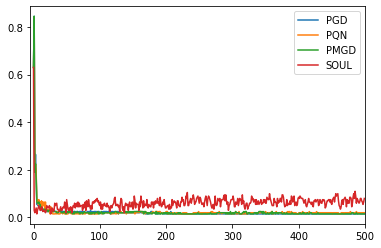

In [ ]:
plt.plot(error_pgd, label='PGD') 
plt.plot(error_pqn, label='PQN')
plt.plot(error_pmga, label='PMGD')
plt.plot(error_soul, label='SOUL')
plt.xlim([-K/100, K])
plt.legend(loc='upper right')

As expected, the error decreases during training for all four algorithms. PGD, PQN, PMGD achieve noticeably smaller errors:

(-5.0, 500.0)

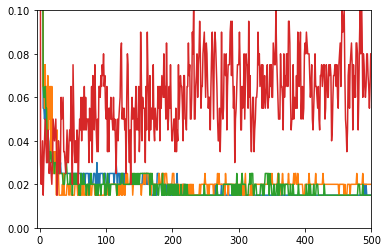

In [ ]:
plt.plot(error_pgd, label='PGD') 
plt.plot(error_pqn, label='PQN')
plt.plot(error_pmga, label='PMGD')
plt.plot(error_soul, label='SOUL')
plt.ylim([0, 0.1])
plt.xlim([-K/100, K])

## Figure 4a

The parameter estimates seem to converge to various local optima:

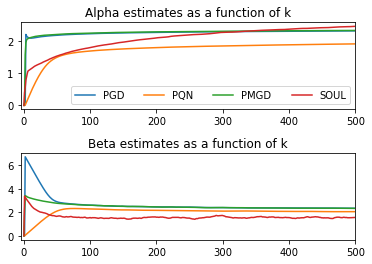

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(a_pgd, label='PGD') 
plt.plot(a_pqn, label='PQN')
plt.plot(a_pmga, label='PMGD')
plt.plot(a_soul, label='SOUL')
plt.title('Alpha estimates as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(b_pgd, label='PGD') 
plt.plot(b_pqn, label='PQN')
plt.plot(b_pmga, label='PMGD')
plt.plot(b_soul, label='SOUL')
plt.title('Beta estimates as a function of k')
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

## Figure 4b

The posterior approximations produced by SOUL are more peaked than those produced by PGD, PQN, and PMGD:

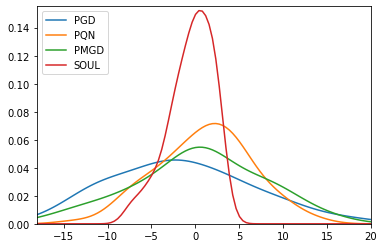

In [ ]:
# Choose a random weight for the input layer:
oi = np.random.randint(0, w0[:, 0, 0].size)  # Output index.
ii = np.random.randint(0, w0[0, :, 0].size)  # Input index.

# Generate KDEs:
from scipy import stats

kde_min = np.min([w_pgd[oi, ii, :], w_pqn[oi, ii, :], 
              w_pmga[oi, ii, :], w_soul[oi, ii, :]])
kde_max = np.max([w_pgd[oi, ii, :], w_pqn[oi, ii, :],
              w_pmga[oi, ii, :], w_soul[oi, ii, :]])
xaxis = np.linspace(kde_min, kde_max, num=100)

kde_pgd = stats.gaussian_kde(w_pgd[oi, ii, :])(xaxis)
kde_pqn = stats.gaussian_kde(w_pqn[oi, ii, :])(xaxis)
kde_pmga = stats.gaussian_kde(w_pmga[oi, ii, :])(xaxis)
kde_soul = stats.gaussian_kde(w_soul[oi, ii, :])(xaxis)

# Plot KDEs:
plt.plot(xaxis, kde_pgd, label='PGD')
plt.plot(xaxis, kde_pqn, label='PQN')
plt.plot(xaxis, kde_pmga, label='PMGD')
plt.plot(xaxis, kde_soul, label='SOUL')
plt.ylim([0, 1.02*kde_soul.max()])
plt.xlim([kde_min, kde_max])
plt.legend(loc='upper left')

## Figure 4c

This is likely the reason why PGD, PQN, and PMGD achieve lower errors than SOUL. We observe the same sort of behaviour if we plot log pointwise predictive densities rather than test errors:

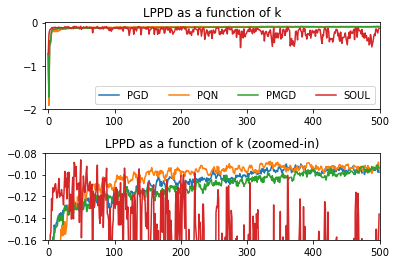

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(lppd_pgd, label='PGD') 
plt.plot(lppd_pqn, label='PQN')
plt.plot(lppd_pmga, label='PMGD')
plt.plot(lppd_soul, label='SOUL')
plt.title('LPPD as a function of k')
plt.xlim([-K/100, K])
plt.legend(loc='lower right', ncol=4)

plt.subplot(2, 1, 2)
plt.plot(lppd_pgd, label='PGD') 
plt.plot(lppd_pqn, label='PQN')
plt.plot(lppd_pmga, label='PMGD')
plt.plot(lppd_soul, label='SOUL')
plt.title('LPPD as a function of k (zoomed-in)')
plt.ylim([-0.16, -0.08])
plt.xlim([-K/100, K])

plt.subplots_adjust(hspace=0.5)

# Table 2

We benchmark the predictive performances and computation times of the algorithms by running them several times. To this end, we remove the per-time-step performance metric calculations from the algorithms: 

In [ ]:
#@title Algorithms without LPPD and test error computations.

def pgd(ltrain, itrain, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    for k in range(K):
        # Temporarily store current particle cloud:
        wk = w  # w components.
        vk = v  # v components.

        # Update parameter estimates (note that we are using the heuristic 
        # discussed in Section 2.1 of the paper; i.e., dividing the alpha-gradient
        # by Dw and the beta-gradient by Dv):'''
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])/Dv)  # Beta.

        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v


def pqn(ltrain, itrain, h, K, a, b, w, v):

    for k in range(K):
        # Temporarily store current particle cloud:
        wk = w  # w components.
        vk = v  # v components.

        # Update parameter estimates:
        a = np.append(a, a[k] + h*ave_grad_param(wk, a[k])
                                  /ave_neg_hess_param(wk, a[k]))  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(vk, b[k])
                                  /ave_neg_hess_param(vk, b[k]))  # Beta.
        
        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

    return a, b, w, v


def pmga(ltrain, itrain, h, K, w, v):
    # Compute initial parameter estimates:
    a = np.array([optimal_param(w)])  # Alpha estimates.
    b = np.array([optimal_param(v)])  # Beta estimates.

    for k in range(K):
        # Temporarily store current particle cloud:
        wk = w  # w components.
        vk = v  # v components.
        
        # Update particle cloud:
        w = (w + h*wgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, w.shape)) 
        v = (v + h*vgrad(wk, vk, a[k], b[k], itrain, ltrain)
               + jnp.sqrt(2*h) * np.random.normal(0, 1, v.shape))

        # Update parameter estimates:
        a = np.append(a, optimal_param(w))  # Alpha.
        b = np.append(b, optimal_param(v))  # Beta.

    return a, b, w, v


def soul(ltrain, itrain, h, K, a, b, w, v):
    # Extract dimensions of latent variables:
    Dw = w[:, :, 0].size  # Dimension of w.
    Dv = v[:, :, 0].size  # Dimension of v.

    for k in range(K):
        # Initliaze new ULA chain at final state of previous ULA chain:
        wkn = w[:, :, -1].reshape((w[:, 0, 0].size, w[0, :, 0].size, 1))
        vkn = v[:, :, -1].reshape((v[:, 0, 0].size, v[0, :, 0].size, 1))

        # Run ULA chain:
        for n in range(w[0, 0, :].size):
            # Take a step:
            wkn = (wkn + h*wgrad(wkn, vkn, a[k], b[k], itrain, ltrain)
                       + jnp.sqrt(2*h) * np.random.normal(0, 1, wkn.shape))
            vkn = (vkn + h*vgrad(wkn, vkn, a[k], b[k], itrain, ltrain)
                       + jnp.sqrt(2*h) * np.random.normal(0, 1, vkn.shape))
            
            # Store state:
            w[:, :, n] = wkn.reshape(w[:, :, 0].shape)
            v[:, :, n] = vkn.reshape(v[:, :, 0].shape)

        # Update parameter estimates (note that we are using the heuristic 
        # discussed in Section 2.1 of the paper; i.e., dividing the 
        # alpha-gradient by Dw and the beta-gradient by Dv):
        a = np.append(a, a[k] + h*ave_grad_param(w, a[k])/Dw)  # Alpha.
        b = np.append(b, b[k] + h*ave_grad_param(v, b[k])/Dv)  # Beta.

    return a, b, w, v

## Predictive performance

We start with the performances:

In [ ]:
M = 10 # Number of runs.
N = 100 # Number of particles.

# Initialize arrays storing the LPPDs and test errors:
lppd_pgd = np.zeros((M))
lppd_pqn = np.zeros((M))
lppd_pmga = np.zeros((M))
lppd_soul = np.zeros((M))

error_pgd = np.zeros((M))
error_pqn = np.zeros((M))
error_pmga = np.zeros((M))
error_soul = np.zeros((M))

for m in range(M):
    print('Run ' + str(m) + ' out of ' + str(M) + '.')
    
    # Randomize the initialization of the particle cloud:
    w0 = np.exp(a0)*np.random.normal(0, 1, (40, 28**2, N))  # w-components.
    v0 = np.exp(b0)*np.random.normal(0, 1, (2, 40, N))  # v-components.
    
    # Randomize the 80/20 testing/training split of the data:
    itrain, itest, ltrain, ltest = train_test_split(images, labels, 
                                                    test_size=0.2,
                                                    random_state=m)

    # Run the algorithms:
    _, _, w_pgd, v_pgd = pgd(ltrain, itrain, h, K, a0, b0, w0, v0)
    _, _, w_pqn, v_pqn = pqn(ltrain, itrain, h, K, a0, b0, w0, v0)
    _, _, w_pmga, v_pmga = pmga(ltrain, itrain, h, K, w0, v0)
    _, _, w_soul, v_soul = soul(ltrain, itrain, h, K, a0, b0, w0, v0)

    # Compute LPPDs:
    lppd_pgd[m] = log_pointwise_predrictive_density(w_pgd, v_pgd, itest, ltest)
    lppd_pqn[m] = log_pointwise_predrictive_density(w_pqn, v_pqn, itest, ltest)
    lppd_pmga[m] = log_pointwise_predrictive_density(w_pmga, v_pmga, itest, ltest)
    lppd_soul[m] = log_pointwise_predrictive_density(w_soul, v_soul, itest, ltest)

    # Compute test errors:
    error_pgd[m] = test_error(w_pgd, v_pgd, itest, ltest)
    error_pqn[m] = test_error(w_pqn, v_pqn, itest, ltest)
    error_pmga[m] = test_error(w_pmga, v_pmga, itest, ltest)
    error_soul[m] = test_error(w_soul, v_soul, itest, ltest)

# Print statistics (mean +- standard deviation):
print('LPPDs:')
print('PGD: '+str(lppd_pgd.mean())+' \u00B1 '+str(lppd_pgd.std())+'.')
print('PQN: '+str(lppd_pqn.mean())+' \u00B1 '+str(lppd_pqn.std())+'.')
print('PMGD: '+str(lppd_pmga.mean())+' \u00B1 '+str(lppd_pmga.std())+'.')
print('SOUL: '+str(lppd_soul.mean())+' \u00B1 '+str(lppd_soul.std())+'.')

print('Test errors:')
print('PGD: '+str(error_pgd.mean())+' \u00B1 '+str(error_pgd.std())+'.')
print('PQN: '+str(error_pqn.mean())+' \u00B1 '+str(error_pqn.std())+'.')
print('PMGD: '+str(error_pmga.mean())+' \u00B1 '+str(error_pmga.std())+'.')
print('SOUL: '+str(error_soul.mean())+' \u00B1 '+str(error_soul.std())+'.')

Run 0 out of 10.
Run 1 out of 10.
Run 2 out of 10.
Run 3 out of 10.
Run 4 out of 10.
Run 5 out of 10.
Run 6 out of 10.
Run 7 out of 10.
Run 8 out of 10.
Run 9 out of 10.
LPPDs:
PGD: -0.0953735001385212 ± 0.018242072099248215.
PQN: -0.09754481539130211 ± 0.02715736094801712.
PMGD: -0.09536587074398994 ± 0.017253154412532334.
SOUL: -0.39398677125573156 ± 0.2067600259955744.
Test errors:
PGD: 0.02349999975413084 ± 0.008958236592023638.
PQN: 0.0254999996162951 ± 0.008500000127755557.
PMGD: 0.02449999935925007 ± 0.010111874069557134.
SOUL: 0.058499998226761815 ± 0.017036723932281367.


## Runtime

Lastly, we obtain runtime statistics using IPython's timeit magic (note that Colab can be set to run on a CPU, GPU, or TPU by selecting Runtime --> Change runtime type --> Hardware accelerator):

In [ ]:
from timeit import repeat

# Time the algorithms:
t_pgd = np.array(repeat(stmt='pgd(ltrain, itrain, h, K, a0, b0, w0, v0)',
                       number=1, repeat=M, globals=globals()))
t_pqn = np.array(repeat(stmt='pqn(ltrain, itrain, h, K, a0, b0, w0, v0)',
                       number=1, repeat=M, globals=globals()))
t_pmga = np.array(repeat(stmt='pmga(ltrain, itrain, h, K, w0, v0)',
                        number=1, repeat=M, globals=globals()))
t_soul = np.array(repeat(stmt='soul(ltrain, itrain, h, K, a0, b0, w0, v0)',
                        number=1, repeat=M, globals=globals()))

# Print statistics (mean +- standard deviation):
print('Runtimes:')
print('PGD: '+str(t_pgd.mean())+' \u00B1 '+str(t_pgd.std())+'.')
print('PQN: '+str(t_pqn.mean())+' \u00B1 '+str(t_pqn.std())+'.')
print('PMGD: '+str(t_pmga.mean())+' \u00B1 '+str(t_pmga.std())+'.')
print('SOUL: '+str(t_soul.mean())+' \u00B1 '+str(t_soul.std())+'.')

Runtimes:
PGD: 74.76778770000018 ± 1.412497029258898.
PQN: 77.87597586999982 ± 0.9440582033750415.
PMGD: 76.48166515999984 ± 0.876956851171763.
SOUL: 185.37313661000007 ± 5.5230289929147105.
